# SGR Creep Compliance: Sub-Diffusive Creep in Biological Soft Matter

> **What is SGR?** The Soft Glassy Rheology (SGR) model is a **statistical mechanics framework** for materials with disordered, metastable microstructures—foams, emulsions, pastes, colloidal gels. It treats the material as mesoscopic "elements" trapped in energy wells of depth $E$, with an effective **noise temperature** $x$ providing thermal-like kicks that enable rearrangements. This trap model produces a genuine **glass transition** at $x=1$, separating solid-like and fluid-like phases.

> **Handbook:** [SGR Conventional](../../docs/source/models/sgr/sgr_conventional.rst) • [SGR Generic](../../docs/source/models/sgr/sgr_generic.rst)

## Key Physics: Sub-Diffusive Creep

SGR predicts **power-law creep compliance** $J(t) \sim t^{x-1}$ for $1 < x < 2$, complementary to the relaxation exponent $(1-x)$. The creep and relaxation exponents sum to zero: $(x-1) + (1-x) = 0$.

**Phase-dependent behavior:**
- **$x < 1$** (glass): $J(t) \to$ constant (solid-like, no flow below yield stress)
- **$1 < x < 2$** (power-law fluid): $J(t) \sim t^{x-1}$ (sub-diffusive, slower than linear)
- **$x = 2$**: Linear creep $J(t) \sim t$ (Newtonian)
- **$x > 2$**: Super-diffusive (unphysical for most soft glasses)

**Biological soft matter** (mucus, cellular networks) often exhibits soft glassy behavior with $1 < x < 2$, reflecting structural rearrangements under constant stress. The trap model captures the combination of elastic caging (short times) and slow structural relaxation (long times).

**Parameters**:
- $x$: Noise temperature — controls creep exponent $(x-1)$
- $G_0$: Elastic modulus — sets compliance magnitude $J \sim 1/G_0$
- $\tau_0$: Microscopic time — sets time scale

## Learning Objectives

1. Fit SGR creep model to biological soft matter data (mucus)
2. Understand $J(t) \sim t^{x-1}$ power-law creep behavior
3. Handle limited data in Bayesian inference (wider posteriors)
4. Connect creep exponent $(x-1)$ to relaxation exponent $(1-x)$

## Prerequisites

- Basic RheoJAX (`basic/01_getting_started.ipynb`)
- Bayesian inference (`bayesian/01_bayesian_intro.ipynb`)

## Runtime

- **Fast mode** (1 chain): ~2 min
- **Production** (4 chains): ~5 min

**Note:** SGRGeneric does NOT support creep — only SGRConventional provides creep predictions.

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional, SGRGeneric

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

## 2. Theory: SGR Creep

The SGR creep compliance is given by:

$$J(t) = \frac{(1 + t/\tau_0)^{2-x}}{G_0 \cdot G_0(x)}$$

where $G_0(x) = \Gamma(2-x)\Gamma(x)/\Gamma(2)$ is the normalization factor.

**Growth exponent:** $(2-x)$

**Phase regimes:**
- $x < 1$: Very slow creep → elastic plateau (glass)
- $1 < x < 2$: Power-law creep (sublinear)
- $x = 2$: Linear creep (Newtonian fluid)
- $x > 2$: Super-diffusive creep

**Biological soft matter** (mucus) often exhibits soft glassy behavior with $1 < x < 2$, reflecting structural rearrangements under constant stress.

## 3. Load Data

In [4]:
data_path = os.path.join("..", "data", "creep", "biological", "creep_mucus_data.csv")
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
t = raw[:, 0]
J_t = raw[:, 1]

print(f"Data points: {len(t)}")
print(f"Time range: {t.min():.1f} – {t.max():.1f} s")
print(f"J(t) range: {J_t.min():.4f} – {J_t.max():.4f} 1/Pa")

Data points: 20
Time range: 0.5 – 10.0 s
J(t) range: 0.9838 – 2.3724 1/Pa


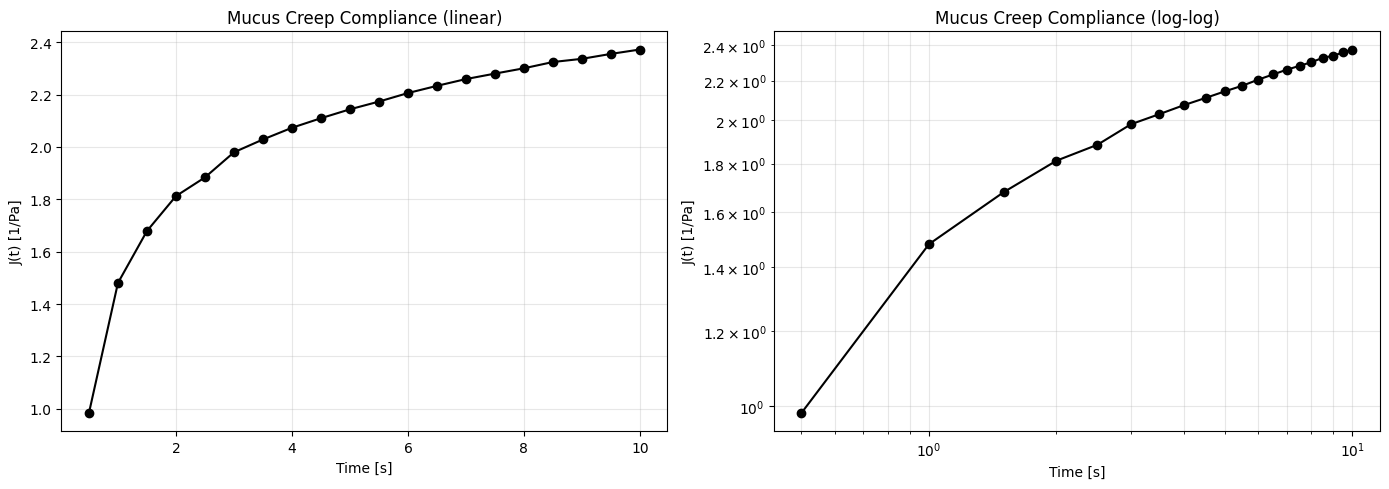

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(t, J_t, "ko-", markersize=6)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("J(t) [1/Pa]")
ax1.set_title("Mucus Creep Compliance (linear)")
ax1.grid(True, alpha=0.3)

ax2.loglog(t, J_t, "ko-", markersize=6)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("J(t) [1/Pa]")
ax2.set_title("Mucus Creep Compliance (log-log)")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [6]:
model = SGRConventional()

t0_fit = time.time()
model.fit(t, J_t, test_mode="creep", method='scipy')
t_nlsq = time.time() - t0_fit

# Compute fit quality
J_pred_fit = model.predict(t)
metrics = compute_fit_quality(J_t, J_pred_fit)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} 1/Pa")
print("\nFitted parameters:")
for name in ["x", "G0", "tau0"]:
    val = model.parameters.get_value(name)
    print(f"  {name:5s} = {val:.4g}")
print(f"Phase regime: {model.get_phase_regime()}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.164805s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=52 | final_cost=0.0681 | elapsed=2.165s | final_gradient_norm=0.5733


NLSQ fit time: 2.68 s
R²: 0.766898
RMSE: 0.1634 1/Pa

Fitted parameters:
  x     = 1.68
  G0    = 996.8
  tau0  = 1.005e-09
Phase regime: power-law


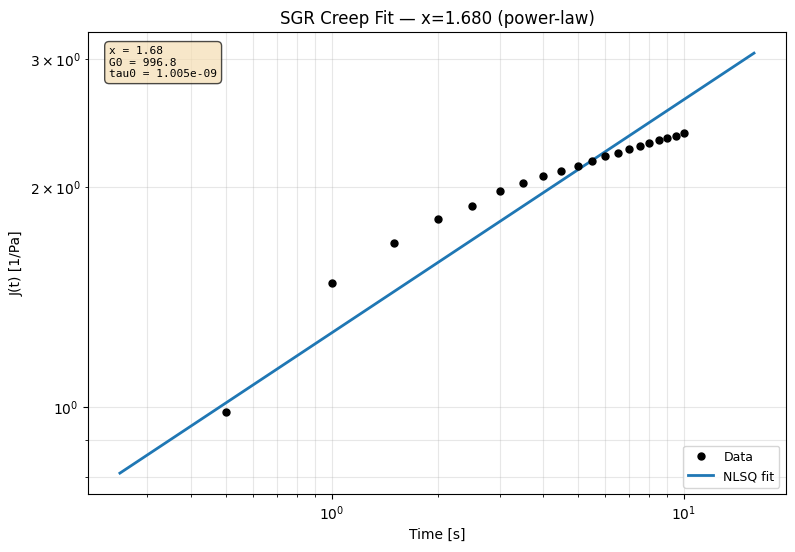

In [7]:
# Plot NLSQ fit with uncertainty band
param_names = ["x", "G0", "tau0"]
x_fit = model.parameters.get_value("x")
fig, ax = plot_nlsq_fit(
    t, J_t, model, test_mode="creep",
    param_names=param_names,
    xlabel="Time [s]", ylabel="J(t) [1/Pa]",
    title=f"SGR Creep Fit — x={x_fit:.3f} ({model.get_phase_regime()})",
)
display(fig)
plt.close(fig)

### 4.1 Creep Regime Exploration

Predict J(t) for different x values to show how the creep exponent changes.

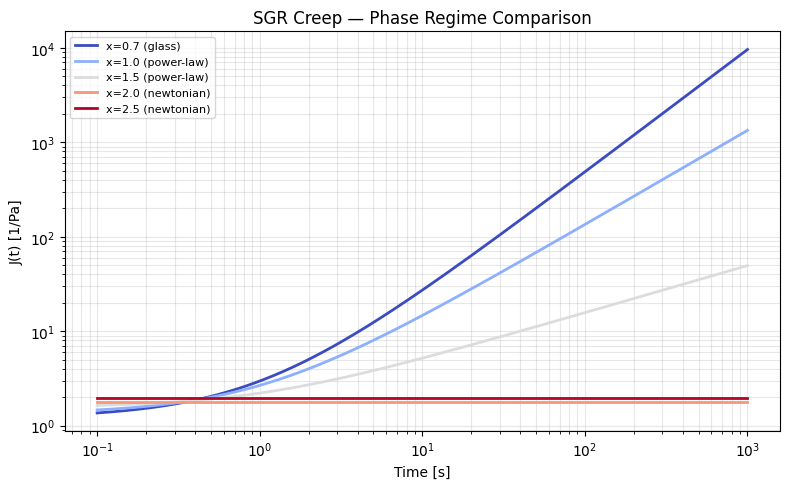

In [8]:
x_values = [0.7, 1.0, 1.5, 2.0, 2.5]
t_sweep = np.logspace(-1, 3, 200)

fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(x_values)))

for i, x_val in enumerate(x_values):
    m = SGRConventional()
    m.parameters.set_value("x", x_val)
    m.parameters.set_value("G0", 1.0)
    m.parameters.set_value("tau0", 1.0)
    m.fitted_ = True
    m._test_mode = "creep"

    J_sweep = m.predict(t_sweep)
    regime = m.get_phase_regime()
    ax.loglog(t_sweep, J_sweep, "-", color=colors[i], lw=2, label=f"x={x_val} ({regime})")

ax.set_xlabel("Time [s]")
ax.set_ylabel("J(t) [1/Pa]")
ax.set_title("SGR Creep — Phase Regime Comparison")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

**Note:** `SGRGeneric` does NOT support creep in `model_function()`. Only `SGRConventional` provides creep predictions. This is a current limitation — `SGRGeneric` supports oscillation, relaxation, and steady_shear.

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

**Note:** With only 20 data points, posteriors will be wider than typical. This is expected and physically meaningful.

In [9]:
initial_values = {name: model.parameters.get_value(name) for name in ["x", "G0", "tau0"]}
print("Warm-start values:", initial_values)

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    t, J_t, test_mode="creep",
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'x': 1.679617194206613, 'G0': 996.7903487478882, 'tau0': 1.004669631877906e-09}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<09:45,  1.19it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   6%|▋         | 45/700 [00:00<00:10, 65.04it/s, 255 steps of size 1.04e-03. acc. prob=0.82]

warmup:  12%|█▏        | 82/700 [00:01<00:05, 117.40it/s, 255 steps of size 8.74e-04. acc. prob=0.84]

warmup:  18%|█▊        | 128/700 [00:01<00:03, 184.72it/s, 127 steps of size 5.34e-02. acc. prob=0.86]

warmup:  26%|██▋       | 185/700 [00:01<00:01, 268.81it/s, 151 steps of size 6.89e-03. acc. prob=0.87]

sample:  33%|███▎      | 231/700 [00:01<00:01, 314.11it/s, 255 steps of size 5.60e-03. acc. prob=0.93]

sample:  39%|███▉      | 276/700 [00:01<00:01, 331.34it/s, 255 steps of size 5.60e-03. acc. prob=0.90]

sample:  46%|████▌     | 319/700 [00:01<00:01, 354.65it/s, 255 steps of size 5.60e-03. acc. prob=0.90]

sample:  52%|█████▏    | 365/700 [00:01<00:00, 382.04it/s, 255 steps of size 5.60e-03. acc. prob=0.90]

sample:  58%|█████▊    | 409/700 [00:01<00:00, 380.01it/s, 67 steps of size 5.60e-03. acc. prob=0.91] 

sample:  64%|██████▍   | 451/700 [00:01<00:00, 390.55it/s, 101 steps of size 5.60e-03. acc. prob=0.90]

sample:  71%|███████   | 496/700 [00:01<00:00, 406.36it/s, 255 steps of size 5.60e-03. acc. prob=0.90]

sample:  77%|███████▋  | 539/700 [00:02<00:00, 398.65it/s, 255 steps of size 5.60e-03. acc. prob=0.90]

sample:  83%|████████▎ | 581/700 [00:02<00:00, 401.67it/s, 255 steps of size 5.60e-03. acc. prob=0.90]

sample:  89%|████████▉ | 626/700 [00:02<00:00, 414.15it/s, 255 steps of size 5.60e-03. acc. prob=0.90]

sample:  96%|█████████▌| 669/700 [00:02<00:00, 410.11it/s, 255 steps of size 5.60e-03. acc. prob=0.90]

sample: 100%|██████████| 700/700 [00:02<00:00, 281.88it/s, 255 steps of size 5.60e-03. acc. prob=0.90]


Bayesian inference time: 4.9 s


### 5.2 Convergence Diagnostics

In [10]:
diag = result.diagnostics
param_names = ["x", "G0", "tau0"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")
n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
         x    1.0238        19
        G0    1.0007        97
      tau0    1.0305        25

Divergences: 0


### 5.3 ArviZ Plots

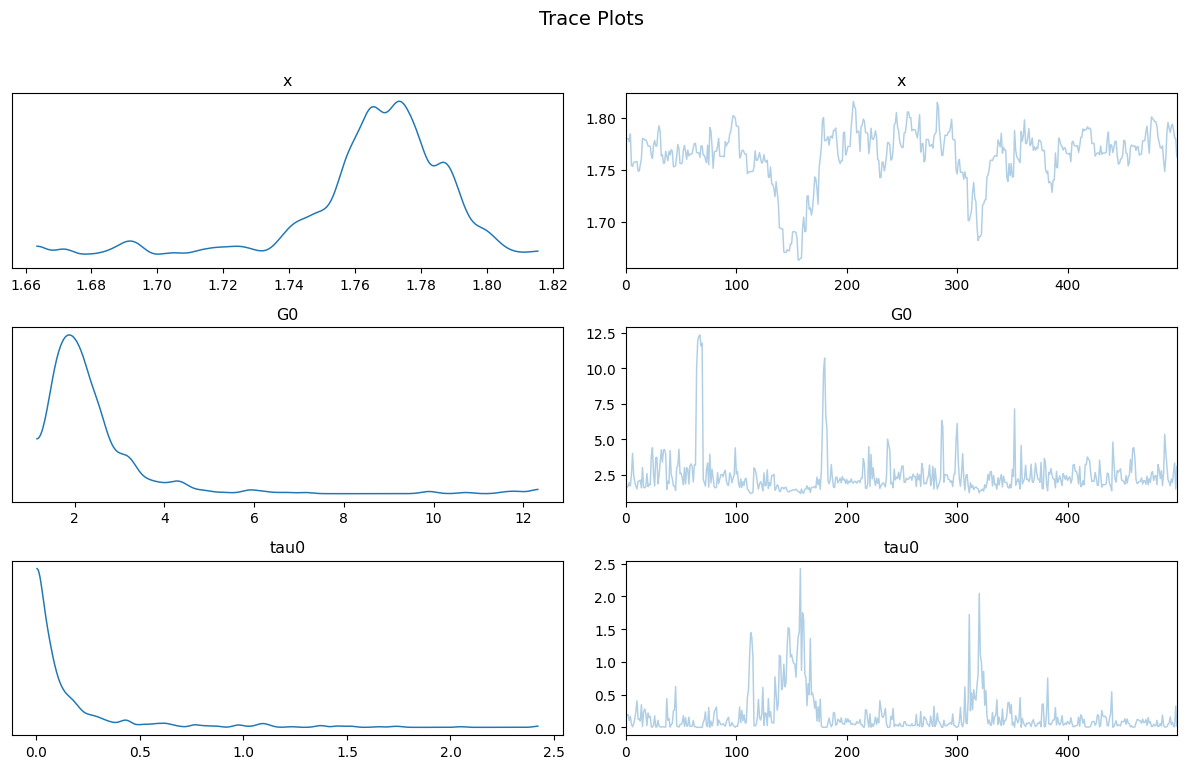

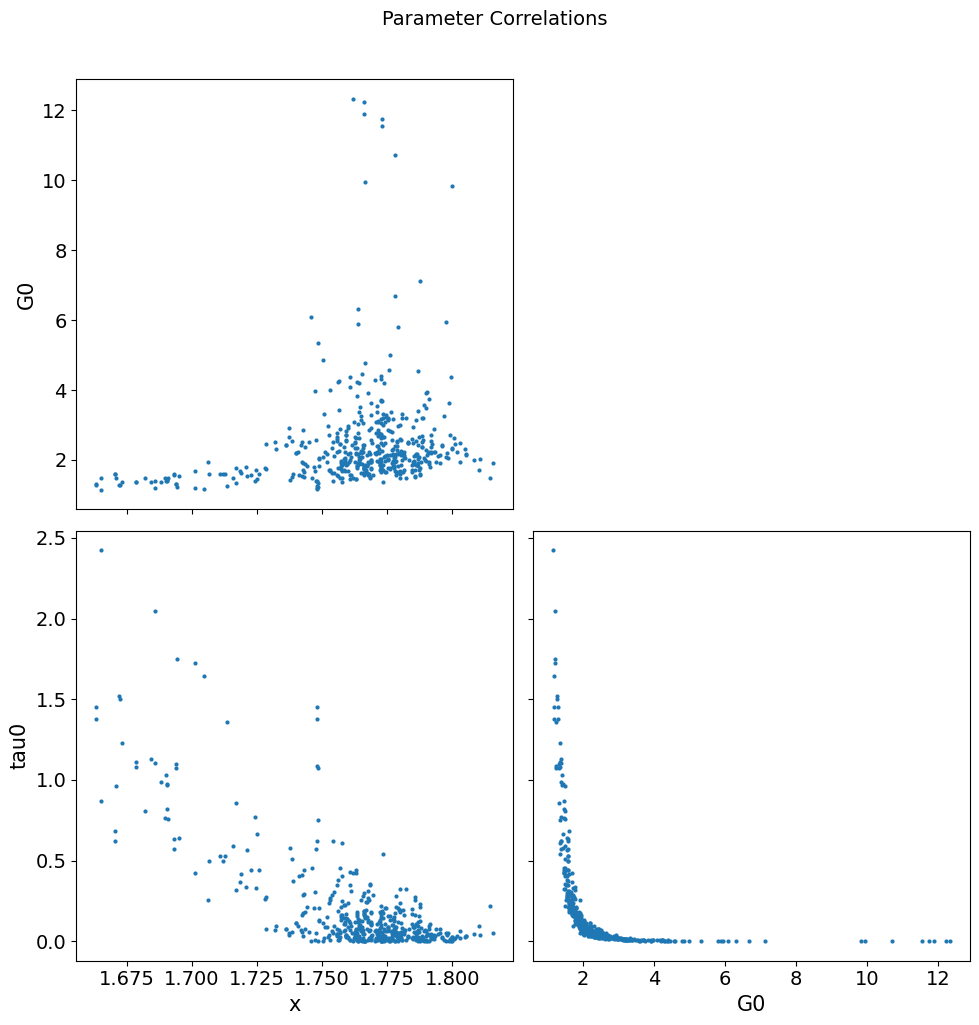

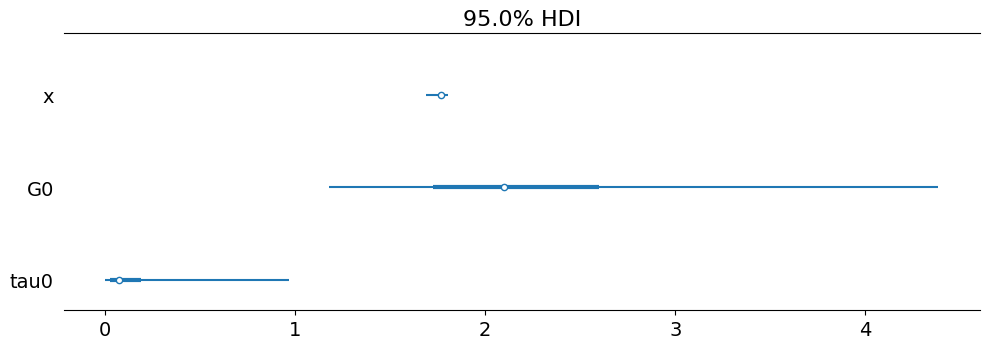

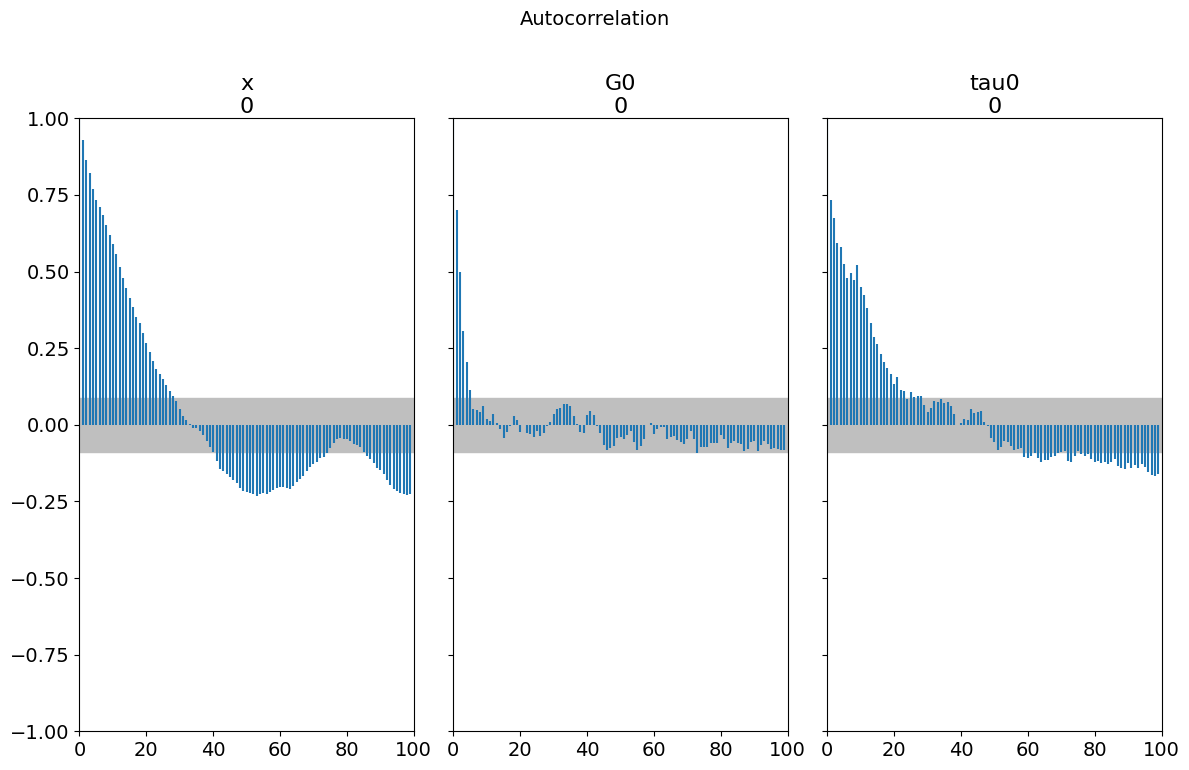

In [11]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
param_names = ["x", "G0", "tau0"]
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 5.4 Posterior Predictive

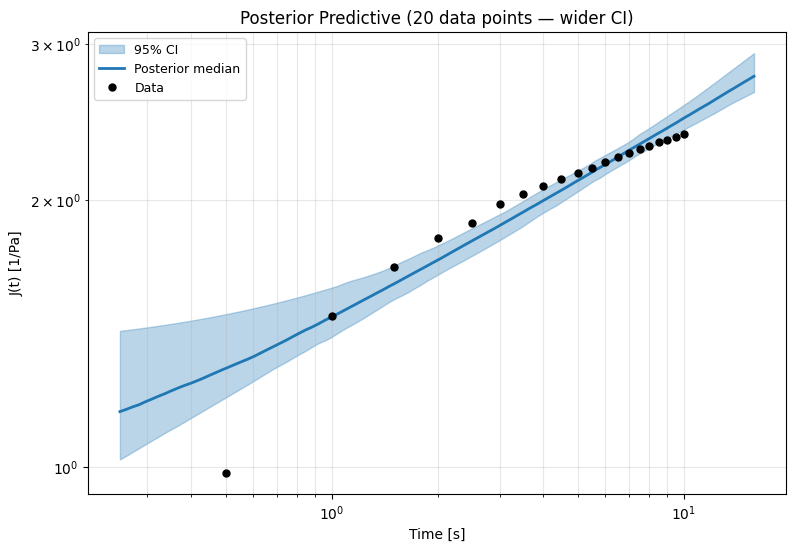

In [12]:
# Posterior predictive with 95% credible intervals
param_names = ["x", "G0", "tau0"]
fig, ax = plot_posterior_predictive(
    t, J_t, model, result,
    test_mode="creep", param_names=param_names,
    xlabel="Time [s]", ylabel="J(t) [1/Pa]",
    title="Posterior Predictive (20 data points — wider CI)",
)
display(fig)
plt.close(fig)

### 5.5 Limited-Data Bayesian Discussion

With only 20 data points, the posteriors are wider — this is expected and informative:

1. **Wider CI reflects genuine uncertainty** from sparse data
2. **The posterior still constrains x meaningfully** — the power-law slope is robust
3. **G₀ and τ₀ may show stronger correlations** (identifiability challenge)
4. **Production runs with 4 chains are especially important here** for R-hat validation

This is a feature, not a bug: Bayesian inference correctly propagates data scarcity into posterior uncertainty.

## 6. Save Results

In [13]:
output_dir = os.path.join("..", "outputs", "sgr", "creep")
os.makedirs(output_dir, exist_ok=True)

nlsq_params = {name: float(model.parameters.get_value(name)) for name in ["x", "G0", "tau0"]}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples (if available)
posterior = getattr(result, "posterior_samples", None) if "result" in dir() else None
if posterior is not None:
    posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
    with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
        json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")


Results saved to ../outputs/sgr/creep/


## Further Reading

- [SGR Conventional Handbook](../../docs/source/models/sgr/sgr_conventional.rst)
- Sollich, P. (1998). Rheological constitutive equation for a model of soft glassy materials. *Phys. Rev. E*, 58, 738–759.
- Fielding, S.M. et al. (2000). Aging and rheology in soft materials. *J. Rheol.*, 44, 323–369.

## Next Steps

- **NB 02**: Relaxation — complementary protocol with exponent $(1-x)$
- **NB 03**: SAOS — frequency-domain view ($G', G'' \sim \omega^{x-1}$)
- **NB 05**: Startup — stress growth and thixotropic overshoot
- **NB 06**: LAOS — nonlinear yielding at large amplitudes